In [1]:
# This is needed so that python finds the utils
import sys
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")

import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from architectures import MnistFC_VAE, MnistFC_CNN_VAE, MnistCNN_VAE
from experiment import mnist_input_fn, mnist_binary_parse_fn
from utils import is_valid_file, setup_eager_checkpoints_and_restore

MNIST_FC_MODEL = "/tmp/miracle_mnist_bern_fc/"
MNIST_FC_CNN_MODEL = "/tmp/miracle_mnist_bern_fc_cnn/"
MNIST_CNN_MODEL = "/tmp/miracle_mnist_bern_cnn/"

MNIST_FC_CNN_GAUSS = "/tmp/miracle_mnist_gauss_fc_cnn_no_batch/"
MNIST_FC_GAUSS = "/tmp/miracle_mnist_gauss_fc_no_batch/"


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
models = {
    "fc": MnistFC_VAE,
    "fc_cnn": MnistFC_CNN_VAE,
    "cnn": MnistCNN_VAE
}

optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=True),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

config = {
        "training_set_size": 60000,
        "max_pixel_value": 1.,

        "num_latents": 40,
        "hidden_units": 300,
        "data_likelihood": "gaussian",

        "batch_size": 128,
        "num_epochs": 20,

        "loss": "neg_elbo",
        "beta": 0.03,
        "learning_rate": 1e-3,
        "optimizer": "adam",

        "log_freq": 250,
        "checkpoint_name": "_ckpt",
    }

In [3]:
num_batches = config["training_set_size"] // config["batch_size"]

((train_data, _),
(test_data, _)) = tf.keras.datasets.mnist.load_data()

train_dataset = mnist_input_fn(train_data[:num_batches * config["batch_size"]],
                               batch_size=config["batch_size"])

# ==========================================================================
# Create VAE model
# ==========================================================================

vae = models["fc_cnn"](hidden_units=config["hidden_units"],
               num_latents=config["num_latents"],
               data_likelihood=config["data_likelihood"])

# Connect the model computational graph by executing a forward-pass
vae(tf.zeros((1, 28, 28)));

# Batch norm shouldn't be fixed now
vae.training_finished()

# ==========================================================================
# Define Checkpoints
# ==========================================================================

global_step = tf.train.get_or_create_global_step()

trainable_vars = vae.get_all_variables() + (global_step,)
checkpoint_dir = os.path.join(MNIST_FC_CNN_GAUSS, "checkpoints")

checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
    variables=trainable_vars,
    checkpoint_dir=checkpoint_dir,
    checkpoint_name=config["checkpoint_name"])

Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /tmp/miracle_mnist_gauss_fc_cnn_no_batch/checkpoints/_ckpt-20, restoring...
Model restored!


In [54]:
# use 4 blocks

block_limit = 15
block_size = 5
num_blocks = 8

uniform_approx_samp_block = i4_sobol_generate(block_size, np.power(2, block_limit), skip=1)
normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

train_tensor = tf.convert_to_tensor(train_data / 255., dtype=tf.float32)
test_tensor = tf.convert_to_tensor(test_data / 255., dtype=tf.float32)

In [57]:
q_mu, q_sigma = vae.encode(test_tensor[100:101, ...])

encoding_indices = []
total_kl = 0

for block_idx in range(num_blocks):
    
    start = block_idx * block_size
    end = (block_idx + 1) * block_size
    
    q_dist_block = tfd.Normal(loc=q_mu[:, start:end], scale=q_sigma[:, start:end])
    p_dist_block = tfd.Normal(loc=tf.zeros_like(q_mu[:, start:end]), scale=tf.ones_like(q_sigma[:, start:end]))

    block_kl = tf.reduce_sum(tfd.kl_divergence(q_dist_block, p_dist_block))
    
    total_kl += block_kl

    print("Block {} KL: {:.2f}, ".format(block_idx, block_kl))

    posterior_log_prob_block = tf.reduce_sum(q_dist_block.log_prob(normal_approx_samp_block), axis=1)
    prior_log_prob_block = tf.reduce_sum(p_dist_block.log_prob(normal_approx_samp_block), axis=1)

    responsibilities_block = posterior_log_prob_block - prior_log_prob_block

    #encoding_index_block = tf.random.categorical(logits=responsibilities_block[tf.newaxis, :], num_samples=1)[0, 0]
    encoding_index_block = tf.argmax(responsibilities_block)
    
    encoding_indices.append(encoding_index_block)

print("Total KL: {:.2f}, ".format(total_kl))

encoding_indices

Block 0 KL: 7.18, 
Block 1 KL: 9.46, 
Block 2 KL: 6.87, 
Block 3 KL: 8.74, 
Block 4 KL: 8.15, 
Block 5 KL: 5.48, 
Block 6 KL: 8.17, 
Block 7 KL: 9.43, 
Total KL: 63.49, 


[<tf.Tensor: id=14797, shape=(), dtype=int64, numpy=14380>,
 <tf.Tensor: id=14863, shape=(), dtype=int64, numpy=14740>,
 <tf.Tensor: id=14929, shape=(), dtype=int64, numpy=1067>,
 <tf.Tensor: id=14995, shape=(), dtype=int64, numpy=15786>,
 <tf.Tensor: id=15061, shape=(), dtype=int64, numpy=28386>,
 <tf.Tensor: id=15127, shape=(), dtype=int64, numpy=25041>,
 <tf.Tensor: id=15193, shape=(), dtype=int64, numpy=15804>,
 <tf.Tensor: id=15259, shape=(), dtype=int64, numpy=5937>]

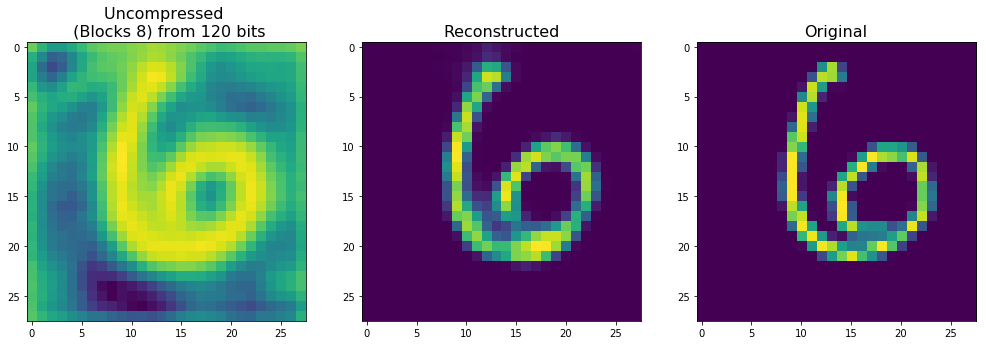

In [58]:
approx_latent = np.concatenate(tuple(map(lambda idx: normal_approx_samp_block[idx, :], encoding_indices)), axis=-1)

decoded_means = vae.decode(tf.convert_to_tensor(approx_latent[tf.newaxis, :], dtype=tf.float32))

#decoded_dist = tfd.Normal(logits=decoded_means)

plt.figure(figsize = (17, 6))
plt.subplot(131)
plt.title("Uncompressed \n (Blocks {}) from {} bits".format(num_blocks, num_blocks * block_limit), fontsize=16)
plt.imshow(decoded_means)

plt.subplot(132)
plt.title("Reconstructed", fontsize=16)
#plt.imshow(np.ones_like(test_tensor[100]))
plt.imshow(vae(test_tensor[100:101, ...]))

plt.subplot(133)
plt.title("Original", fontsize=16)
plt.imshow(test_data[100])

plt.show()